In [1]:
import glob
import random
import pandas
import numpy
import astropy
import astropy.convolution
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
labels = pandas.read_csv('labels.csv')

In [4]:
def compute_waves(hdulist):
    header = hdulist[0].header
    w = astropy.wcs.WCS(header)
    pixcrd = numpy.arange(header['NAXIS1'])
    return w.all_pix2world(pixcrd, 0)[0]

def get_spectrum(hdulist):
    waves = compute_waves(hdulist)
    fluxes = hdulist[0].data
    return waves, fluxes

def air2vacuum(air_waves):
    # http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion    
    ss = ((10 ** 4) / air_waves) ** 2
    return air_waves * (1 + 0.00008336624212083 + 0.02408926869968 / \
            (130.1065924522 - ss) + 0.0001599740894897 / (38.92568793293 - ss))

def convolve_fluxes(fluxes, kernel=astropy.convolution.Gaussian1DKernel(stddev=7)):
    return astropy.convolution.convolve(fluxes, kernel, boundary='extend')

def resample_fluxes(waves, fluxes, new_waves=numpy.linspace(6519, 6732, 140)):
    return numpy.interp(new_waves, waves, fluxes)

def preprocess_fluxes(waves, fluxes):
    vacuum_waves = air2vacuum(waves)
    convolved_fluxes = convolve_fluxes(fluxes)
    resampled_fluxes = resample_fluxes(vacuum_waves, convolved_fluxes)
    return resampled_fluxes

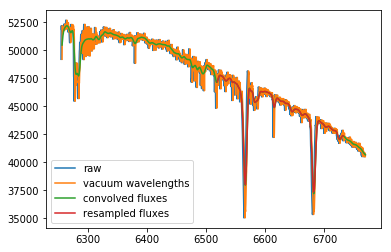

In [5]:
with astropy.io.fits.open(random.choice(glob.glob('data/*'))) as hdulist:
    air_waves, fluxes = get_spectrum(hdulist)
    plt.plot(air_waves, fluxes, label='raw')
    vacuum_waves = air2vacuum(air_waves)
    plt.plot(vacuum_waves, fluxes, label='vacuum wavelengths')
    convolved_fluxes = convolve_fluxes(fluxes)
    plt.plot(vacuum_waves, convolved_fluxes, label='convolved fluxes')
    resampled_fluxes = resample_fluxes(vacuum_waves, convolved_fluxes)
    plt.plot(numpy.linspace(6519, 6732, 140), resampled_fluxes, label='resampled fluxes')
    plt.legend()

In [6]:
spectra = {}
for index, name, label in labels.itertuples():
    with astropy.io.fits.open('data/' + name + '.fits') as hdulist: 
        header = hdulist[0].header
        spectra[index] = {'fluxes': preprocess_fluxes(*get_spectrum(hdulist)),
                          'id': name,
                          'label': label,
                          'object': header['OBJECT'],
                          'ra': header['RA'],
                          'dec': header['DEC'],
                          'expval': header['EXPVAL'],
                          'gratang': header['GRATANG'],
                          'detector': header['DETECTOR'],
                          'chipid': header['CHIPID'],
                          'specfilt': header['SPECFILT'],
                          'date-obs': header['DATE-OBS'],
                          'dichmir': header['DICHMIR']}

df = pandas.DataFrame.from_dict(spectra, orient='index')
df[numpy.linspace(6519, 6732, 140)] = pandas.DataFrame(df['fluxes'].values.tolist())
del df['fluxes']
df = df.set_index('id')
df.to_csv('ondrejov-dataset.csv')
df.head()

,expval,chipid,gratang,object,label,dichmir,ra,dec,specfilt,date-obs,...,6718.20863309,6719.74100719,6721.27338129,6722.8057554,6724.3381295,6725.8705036,6727.4028777,6728.9352518,6730.4676259,6732.0
id,,,,,,,,,,,,,,,,,,,,,
a201306060018,5.056532,E2V 42-10 BX,30.25,beta Lyr,0,2,18:50:04.787,+33:21:45.60,1,2013-06-06,...,44950.487947,45019.574545,44910.009841,44719.100229,44689.037403,44724.791337,44700.993767,44705.082297,44752.548428,44734.531766
a201306060019,15.040130,E2V 42-10 BX,30.25,beta Lyr,0,2,18:50:04.787,+33:21:45.60,1,2013-06-06,...,125795.778619,126004.868747,125788.287910,125227.841525,125145.712758,125330.650720,125332.395056,125338.057872,125376.976633,125252.358114
a201306070013,5.032879,E2V 42-10 BX,30.25,bet lyr,0,2,18:50:04.787,+33:21:45.60,1,2013-06-07,...,84611.753745,84165.891840,84226.201429,84235.867331,83974.378800,83914.877044,84138.727554,84272.860752,84292.101858,84276.482578
a201306080018,0.494122,E2V 42-10 BX,30.25,V2174 Cyg,0,2,21:58:29.760,+54:29:05.50,1,2013-06-09,...,8647.713731,8635.493316,8639.129072,8646.465059,8651.837476,8647.120557,8637.089774,8633.938559,8631.665362,8615.235015
a201306080020,1.356480,E2V 42-10 BX,30.25,V1362 Cyg,0,2,20:03:41.600,+36:25:32.10,1,2013-06-09,...,15817.238795,15741.212936,15722.340911,15763.497520,15768.432981,15744.330622,15747.138683,15749.311941,15717.322175,15685.097417
